              precision    recall  f1-score   support

         0.0       0.68      0.85      0.76       123
         1.0       0.65      0.41      0.50        83

    accuracy                           0.67       206
   macro avg       0.67      0.63      0.63       206
weighted avg       0.67      0.67      0.66       206

Confusion Matrix:
[[105  18]
 [ 49  34]]


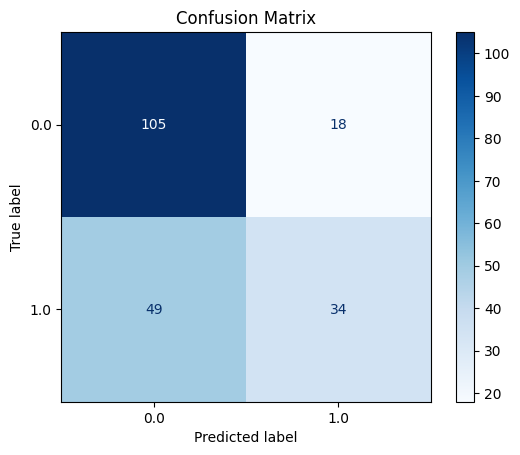

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin

class AuthorRatingMapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.rating_map = {
            "Novice": 1,
            "Intermediate": 2,
            "Famous": 3,
            "Excellent": 4
        }
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        if 'Author_Rating' in X.columns:
            X['Author_Rating'] = X['Author_Rating'].map(self.rating_map)
        return X

df = pd.read_csv("book_data_clean.csv", sep=";", encoding="utf-8")

y = df['Adapted_to_Film']
X = df.drop(columns=['Adapted_to_Film', 'Book_Name'])

top_publishers = X['Publisher'].value_counts().nlargest(10).index
X['Publisher'] = X['Publisher'].where(X['Publisher'].isin(top_publishers), other='other')
top_authors = X['Author'].value_counts().nlargest(10).index
X['Author'] = X['Author'].where(X['Author'].isin(top_authors), other='Sonstige')

numerical_features = ['Publishing_Year', 'Author_Rating', 'Average_Rating', 'Rating_Count', 'Gross_Sales_EUR']
categorical_features = ['Language_Code', 'Genre', 'Publisher', 'Author']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

pipeline = Pipeline(steps=[
    ('author_rating_mapper', AuthorRatingMapper()),
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Vorhersagen (du hast y_pred schon)
# y_pred = pipeline.predict(X_test)

# Confusion Matrix berechnen
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix ausgeben
print("Confusion Matrix:")
print(cm)

# Confusion Matrix visualisieren
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

